In [ ]:
!pip install -q transformers torch wordcloud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from torch.nn.functional import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind


In [ ]:
comments_df = pd.read_csv("comments.csv")
posts_df = pd.read_csv("posts.csv")

# Merge timestamps from posts into comments
merged_df = comments_df.merge(posts_df[['permalink', 'created_utc']],
                               left_on='post_permalink', right_on='permalink', how='left')
merged_df['comment_timestamp'] = pd.to_datetime(merged_df['created_utc'], unit='s')
merged_df.drop(columns=['permalink', 'created_utc'], inplace=True)


In [ ]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
def get_sentiment(text):
    try:
        encoded_input = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
        with torch.no_grad():
            output = model(**encoded_input)
            scores = softmax(output.logits, dim=1)[0]
            label_map = {0: "negative", 1: "neutral", 2: "positive"}
            predicted_class = torch.argmax(scores).item()
            return label_map[predicted_class], float(scores[predicted_class])
    except:
        return "error", 0.0


In [ ]:
import os

# Try to resume from previous progress
if os.path.exists("sentiment_progress.csv"):
    print("🔁 Resuming from previous progress...")
    merged_df = pd.read_csv("sentiment_progress.csv")
else:
    merged_df['predicted_label'] = ""
    merged_df['confidence'] = 0.0

# Find where we left off
start_index = merged_df[merged_df['predicted_label'] == ""].index.min()
if pd.isna(start_index):
    start_index = len(merged_df)

# Start/resume the sentiment loop
for i in range(start_index, len(merged_df)):
    label, score = get_sentiment(str(merged_df.at[i, 'comment_body']))
    merged_df.at[i, 'predicted_label'] = label
    merged_df.at[i, 'confidence'] = score

    # Save every 1000 rows
    if i % 1000 == 0 or i == len(merged_df) - 1:
        merged_df.to_csv("sentiment_progress.csv", index=False)
        print(f"💾 Saved progress at {i}/{len(merged_df)}")

print("✅ Sentiment analysis complete!")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

💾 Saved progress at 0/22991
💾 Saved progress at 1000/22991
💾 Saved progress at 2000/22991
💾 Saved progress at 3000/22991
💾 Saved progress at 4000/22991
💾 Saved progress at 5000/22991
💾 Saved progress at 6000/22991
💾 Saved progress at 7000/22991
💾 Saved progress at 8000/22991
💾 Saved progress at 9000/22991
💾 Saved progress at 10000/22991
💾 Saved progress at 11000/22991
💾 Saved progress at 12000/22991
💾 Saved progress at 13000/22991
💾 Saved progress at 14000/22991
💾 Saved progress at 15000/22991
💾 Saved progress at 16000/22991
💾 Saved progress at 17000/22991
💾 Saved progress at 18000/22991
💾 Saved progress at 19000/22991
💾 Saved progress at 20000/22991
💾 Saved progress at 21000/22991
💾 Saved progress at 22000/22991
💾 Saved progress at 22990/22991
✅ Sentiment analysis complete!


In [ ]:
spec_terms = ["quick flip", "get in", "get out", "exit early", "10x", "moon", "pump", "dump"]
pattern = '|'.join(spec_terms)
merged_df['is_speculative'] = merged_df['comment_body'].str.contains(pattern, case=False, na=False)


In [ ]:
text_data = merged_df['comment_body'].dropna().astype(str).tolist()
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
X = vectorizer.fit_transform(text_data)

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)
topic_distribution = lda.transform(X)
dominant_topic = topic_distribution.argmax(axis=1)

merged_df = merged_df.loc[merged_df['comment_body'].notna()].copy().reset_index(drop=True)
merged_df['topic_num'] = dominant_topic
topic_labels = {
    0: "Scam/Rug Pull Concerns",
    1: "Moderation & Reddit Comments",
    2: "Trump & Political Reactions",
    3: "Sarcasm, Grift & Humor",
    4: "Coin Speculation & Crypto Trading"
}
merged_df['topic_label'] = merged_df['topic_num'].map(topic_labels)



In [ ]:
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
merged_df['sentiment_score'] = merged_df['predicted_label'].map(sentiment_map)
merged_df['time_bin'] = merged_df['comment_timestamp'].dt.floor('4H')


<ipython-input-10-83e8efdb20db>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  merged_df['time_bin'] = merged_df['comment_timestamp'].dt.floor('4H')


In [ ]:
price_df = pd.read_excel("kraken_TRUMPUSDT_4h_data.xlsx")
price_df['Time'] = pd.to_datetime(price_df['Time'])

sentiment_avg = merged_df.groupby('time_bin')['sentiment_score'].mean().reset_index()
sentiment_avg.rename(columns={'time_bin': 'Time', 'sentiment_score': 'avg_sentiment'}, inplace=True)
price_sentiment_df = pd.merge(price_df, sentiment_avg, on='Time', how='left')


In [ ]:
rugpull_time = pd.to_datetime("2024-04-23 00:00:00")
pre = price_sentiment_df[price_sentiment_df['Time'] < rugpull_time]['avg_sentiment'].dropna()
post = price_sentiment_df[price_sentiment_df['Time'] >= rugpull_time]['avg_sentiment'].dropna()
t_stat, p_value = ttest_ind(pre, post, equal_var=False)


/usr/local/lib/python3.11/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [ ]:
topic_trend = merged_df.groupby(['topic_label', 'time_bin'])['sentiment_score'].mean().reset_index()


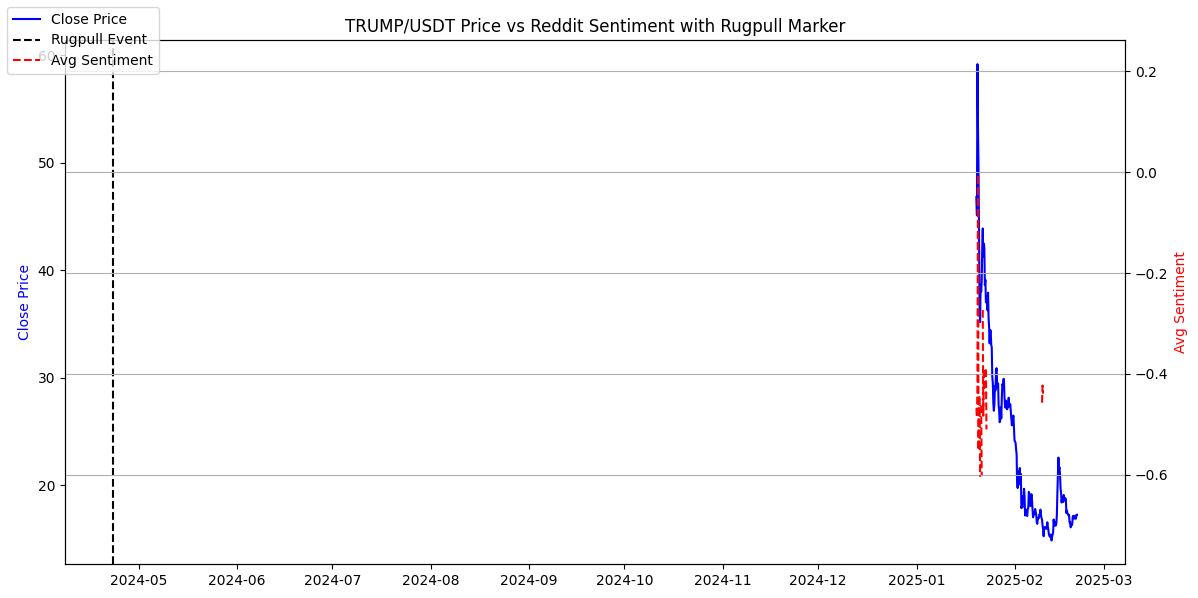

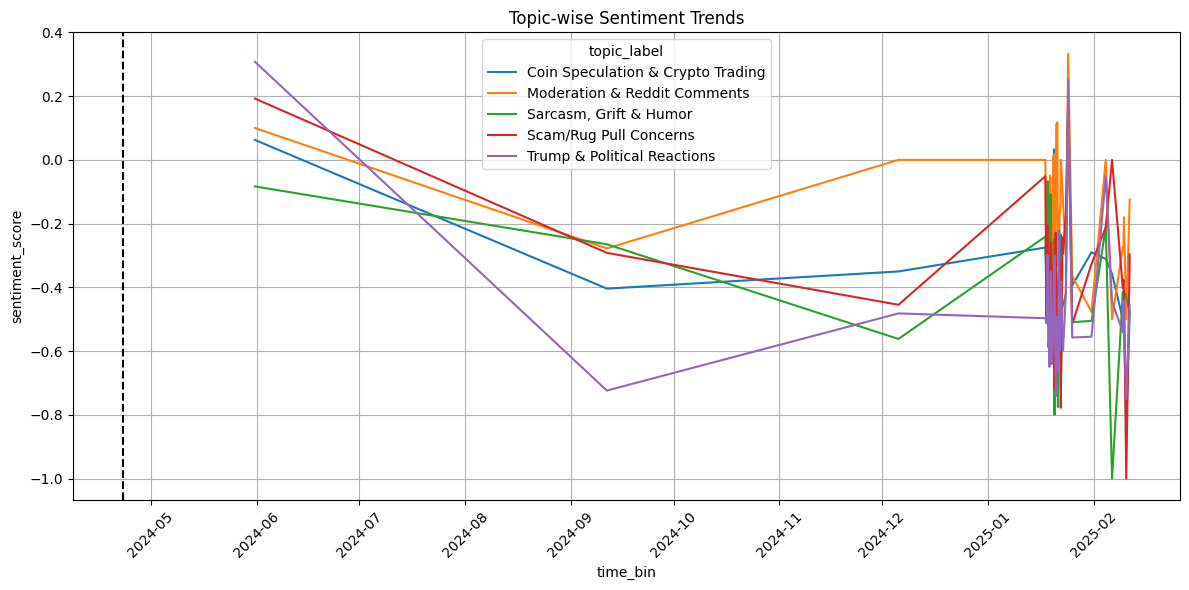

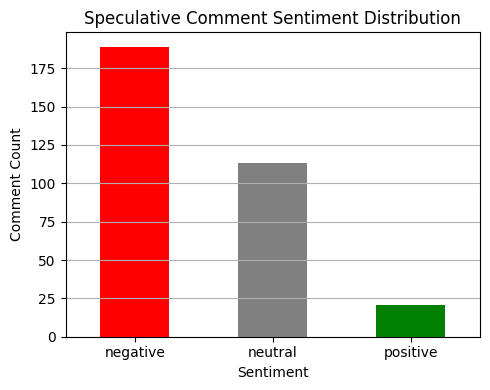

In [ ]:
# 13.1 Price vs Sentiment over time
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(price_sentiment_df['Time'], price_sentiment_df['Close'], color='blue', label='Close Price')
ax1.axvline(x=rugpull_time, color='black', linestyle='--', label='Rugpull Event')
ax2 = ax1.twinx()
ax2.plot(price_sentiment_df['Time'], price_sentiment_df['avg_sentiment'], color='red', linestyle='--', label='Avg Sentiment')
ax1.set_ylabel("Close Price", color='blue')
ax2.set_ylabel("Avg Sentiment", color='red')
plt.title("TRUMP/USDT Price vs Reddit Sentiment with Rugpull Marker")
fig.legend(loc="upper left")
plt.grid()
plt.tight_layout()
plt.show()

# 13.2 Topic sentiment trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=topic_trend, x='time_bin', y='sentiment_score', hue='topic_label')
plt.axvline(x=rugpull_time, color='black', linestyle='--')
plt.title("Topic-wise Sentiment Trends")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# 13.3 Speculative sentiment bar chart
spec_df = merged_df[merged_df['is_speculative'] & (merged_df['comment_score'] >= 5)]
plt.figure(figsize=(5, 4))
spec_df['predicted_label'].value_counts().plot(kind='bar', color=['red', 'gray', 'green'])
plt.title("Speculative Comment Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Comment Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



📌 Speculative Comment Sentiment Distribution:
predicted_label
negative    0.585139
neutral     0.349845
positive    0.065015
Name: proportion, dtype: float64

📌 Sentiment Shift Test (T-Test):
Pre-rugpull avg sentiment: nan
Post-rugpull avg sentiment: -0.4127380472120405
T-statistic: nan
P-value: nan


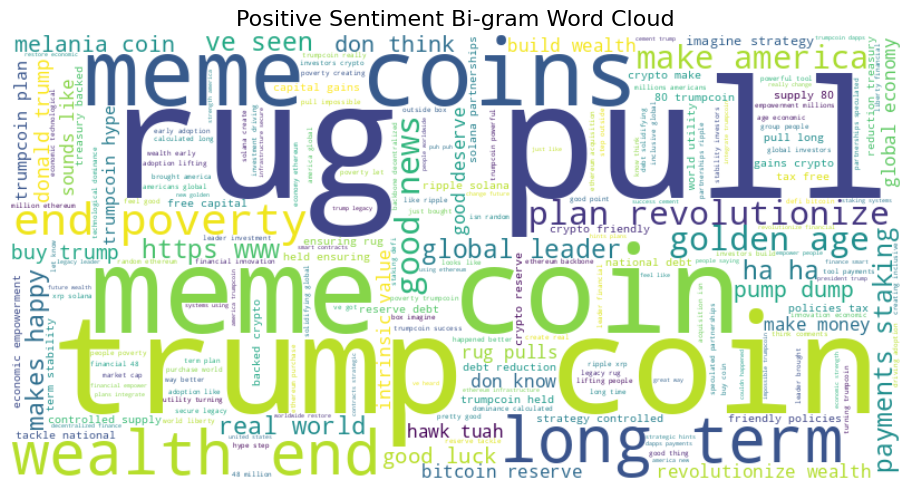

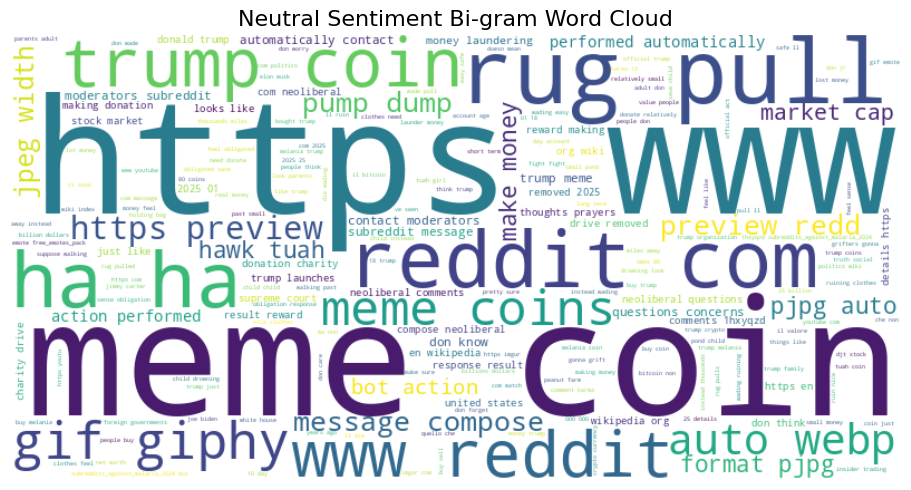

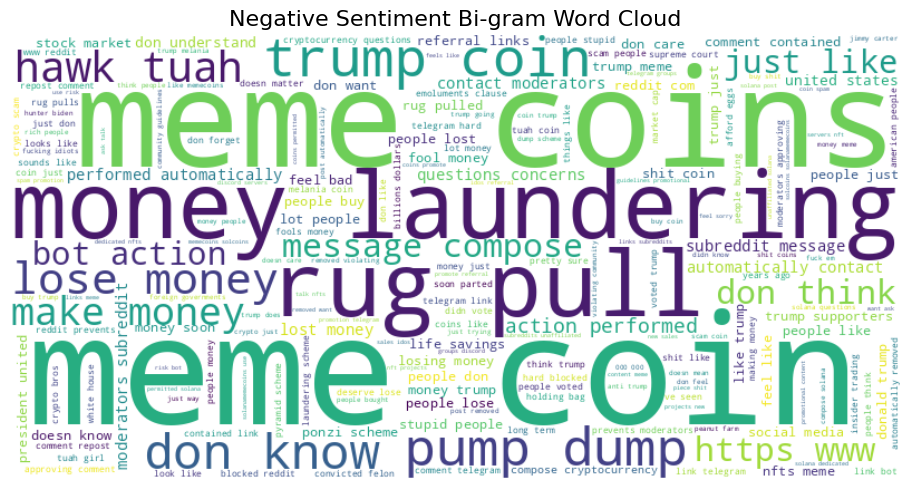

In [ ]:
print("\n📌 Speculative Comment Sentiment Distribution:")
print(spec_df['predicted_label'].value_counts(normalize=True))

print("\n📌 Sentiment Shift Test (T-Test):")
print("Pre-rugpull avg sentiment:", pre.mean())
print("Post-rugpull avg sentiment:", post.mean())
print("T-statistic:", t_stat)
print("P-value:", p_value)

#Plots:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

def generate_bigrams(text_series):
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    X = vectorizer.fit_transform(text_series)
    sum_words = X.sum(axis=0)
    bigram_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)
    return dict(bigram_freq)

def plot_bigram_wordcloud(frequencies, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Loop through each sentiment and plot
for sentiment in ['positive', 'neutral', 'negative']:
    text_series = merged_df[merged_df['predicted_label'] == sentiment]['comment_body'].dropna().astype(str)
    bigrams = generate_bigrams(text_series)
    plot_bigram_wordcloud(bigrams, f"{sentiment.capitalize()} Sentiment Bi-gram Word Cloud")


In [ ]:
export_df = merged_df[[
    'comment_body',
    'comment_score',
    'comment_timestamp',
    'predicted_label',
    'confidence',
    'is_speculative',
    'topic_num',
    'topic_label'
]]
export_df.to_csv("final_comments_labeled.csv", index=False)
print("\n Final labeled file exported as: final_comments_labeled.csv")



 Final labeled file exported as: final_comments_labeled.csv


In [ ]:
from google.colab import files
files.download("final_comments_labeled.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>